In [9]:
from typing import Union, Optional
from dataclasses import dataclass
import math

import tensorflow as tf
import numpy as np
import PIL.Image as Image

In [2]:
tf.__version__

'2.7.0'

In [3]:
lena = Image.open("imgs/Lenna512.png")
lists = Image.open("imgs/Lists512.png")
imgs = [np.array(i) / 255.0 for i in [lena, lists]]
imgs

[array([[[0.87843137, 0.51372549, 0.42352941],
         [0.8745098 , 0.50980392, 0.42352941],
         [0.87058824, 0.52156863, 0.43529412],
         ...,
         [0.81568627, 0.39607843, 0.36862745],
         [0.78823529, 0.36078431, 0.32941176],
         [0.72156863, 0.30980392, 0.31764706]],
 
        [[0.88235294, 0.51372549, 0.41960784],
         [0.8745098 , 0.51372549, 0.41960784],
         [0.8745098 , 0.5254902 , 0.43137255],
         ...,
         [0.78823529, 0.38039216, 0.36078431],
         [0.74117647, 0.31372549, 0.30980392],
         [0.62745098, 0.21568627, 0.26666667]],
 
        [[0.88235294, 0.51764706, 0.41960784],
         [0.8745098 , 0.51764706, 0.41568627],
         [0.8745098 , 0.52156863, 0.42352941],
         ...,
         [0.74509804, 0.3372549 , 0.34901961],
         [0.6627451 , 0.25882353, 0.30588235],
         [0.54117647, 0.14117647, 0.24313725]],
 
        ...,
 
        [[0.31764706, 0.08235294, 0.23137255],
         [0.32156863, 0.07843137, 0.22745

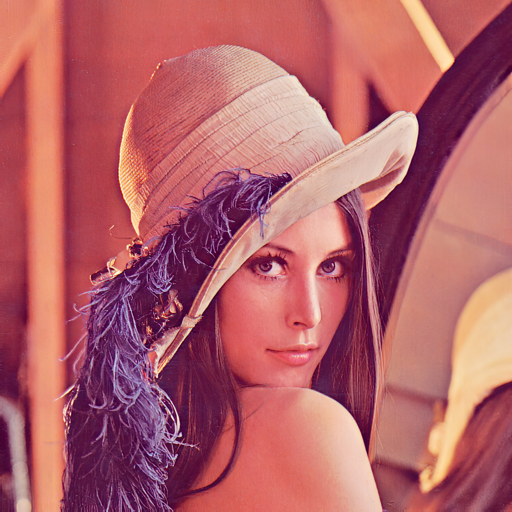

In [4]:
lena

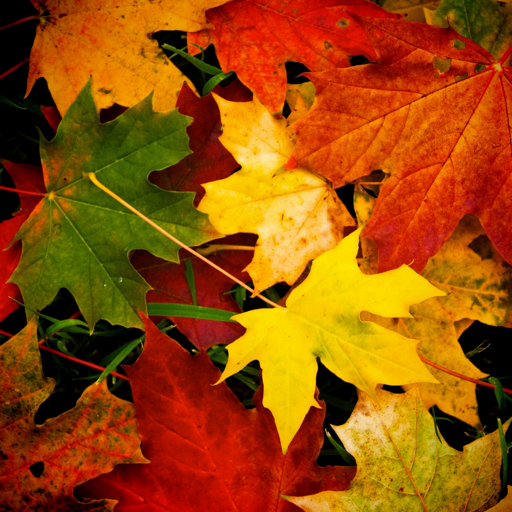

In [5]:
lists

In [6]:
def make_gauss_blur_kernel(size: int, scale: float = 3) -> np.ndarray:
    result = np.zeros(shape=[size], dtype=float)
    center = (size - 1) // 2
    div = ((center / scale) ** 2) * 2
    for i in range(size):
        x2 = (center - i)**2
        result[i] = math.exp( -x2 / div)
    return result / np.sum(result)

make_gauss_blur_kernel(11)

array([0.00266126, 0.01344761, 0.0474085 , 0.11660608, 0.20009684,
       0.23955941, 0.20009684, 0.11660608, 0.0474085 , 0.01344761,
       0.00266126])

In [7]:
@dataclass
class Report:
    image: np.ndarray
    gradient: np.ndarray
    image_source: np.ndarray
    loss_precise: float
    loss_gauss: float
    loss: float

class MyModel:
    def __init__(self, img_h: int, img_w: int, gauss_kernel_size: int, image_source: Optional[np.ndarray] = None):
        if image_source is None:
            image_source = np.zeros(shape=(1, img_h, img_w, 3), dtype=float)
        self.trainable_image = tf.Variable(initial_value=image_source, trainable=True)
        gauss_blur_kernel = make_gauss_blur_kernel(size=gauss_kernel_size, scale=3)
        self.gauss_kernel_x = tf.constant(gauss_blur_kernel[np.newaxis, :, np.newaxis, np.newaxis] * np.ones(shape=(1, 1, 3, 1)))
        self.gauss_kernel_y = tf.constant(gauss_blur_kernel[:, np.newaxis, np.newaxis, np.newaxis] * np.ones(shape=(1, 1, 3, 1)))

    def run(self, img_precise: np.ndarray, img_gauss: np.ndarray, m_precise = 1, m_gauss = 1) -> Report:
        with tf.GradientTape() as tape:
            trainable_image01 = tf.math.sigmoid(self.trainable_image)
            ## precise
            loss_precise = tf.reduce_sum(tf.square(trainable_image01 - img_precise[np.newaxis, :, :, :]))
            ## do gamma-correction, gaussian blur and inverted gamma-correction
            blurred = self.gauss_blur(trainable_image01 ** 2.2) ** (1.0 / 2.2)
            blurred_label = self.gauss_blur(img_gauss[np.newaxis, :, :, :] ** 2.2) ** (1.0 / 2.2)
            loss_gauss = tf.reduce_sum(tf.square(blurred - blurred_label))

            loss = loss_precise * m_precise + loss_gauss * m_gauss
        gradient = tape.gradient(loss, self.trainable_image)
        return Report(
            image=trainable_image01.numpy()[0],
            gradient=gradient.numpy(),
            image_source=self.trainable_image.numpy(),
            loss_precise=loss_precise.numpy(),
            loss_gauss=loss_gauss.numpy(),
            loss=loss.numpy(),
        )

    def apply_gradient(self, grad: np.ndarray, lr: float):
        self.trainable_image.assign(self.trainable_image.numpy() - lr * grad)

    def gauss_blur(self, inp: Union[tf.Tensor, np.ndarray]) -> tf.Tensor:
        r = inp
        r = tf.nn.depthwise_conv2d(r, self.gauss_kernel_x, strides=[1,1,1,1], padding='SAME')
        r = tf.nn.depthwise_conv2d(r, self.gauss_kernel_y, strides=[1,1,1,1], padding='SAME')
        return r

    def train(self, steps_count: int, print_loss_steps: int, lr: float, **run_kwargs) -> Report:
        for i in range(steps_count):
            r = self.run(**run_kwargs)
            model.apply_gradient(r.gradient, lr)
            if i % print_loss_steps == print_loss_steps - 1:
                print(f"{i}: loss = {r.loss}, precise = {r.loss_precise}, gauss = {r.loss_gauss}")
        return r

49: loss = 5027.804245504113, precise = 7085.696479140452, gauss = 4319.234597590068
99: loss = 1411.5786189766084, precise = 2986.607768574152, gauss = 1112.9178421191932
149: loss = 633.9480359549668, precise = 1859.3875716894372, gauss = 448.00927878602306
199: loss = 363.87179621925304, precise = 1342.3625421604027, gauss = 229.6355420032128


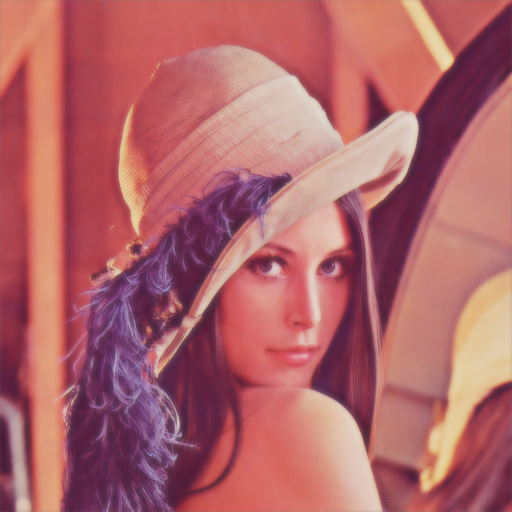

In [8]:
model = MyModel(512, 512, gauss_kernel_size=15)
r = model.train(steps_count=200, print_loss_steps=50, lr=0.2, img_precise=imgs[0], img_gauss=imgs[0], m_precise=0.1, m_gauss=1.0)
Image.fromarray(np.uint8(r.image * 255.0))

49: loss = 17095.45197235873, precise = 51722.225479028035, gauss = 11923.229424455927
99: loss = 14234.48955997771, precise = 57792.23266754155, gauss = 8455.266293223554
149: loss = 12725.340904469027, precise = 62030.71181252076, gauss = 6522.26972321695
199: loss = 11829.511342959357, precise = 65119.44840513915, gauss = 5317.566502445441
249: loss = 11251.479676946105, precise = 67455.10720896609, gauss = 4505.968956049495
299: loss = 10854.887394662692, precise = 69276.64593008399, gauss = 3927.222801654292
349: loss = 10569.77211889266, precise = 70734.14697234065, gauss = 3496.3574216585957
399: loss = 10357.173849478915, precise = 71925.60662064928, gauss = 3164.6131874139865
449: loss = 10193.942980781296, precise = 72917.26294294497, gauss = 2902.216686486798
499: loss = 10065.583963826402, precise = 73755.27658098633, gauss = 2690.0563057277686
549: loss = 9962.62040610813, precise = 74472.69694876877, gauss = 2515.3507112312527
599: loss = 9878.630287282249, precise = 7509

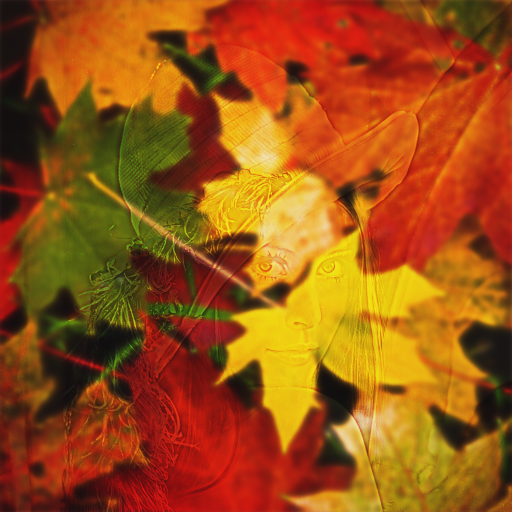

In [9]:
for i in range(1000):
    r = model.run(imgs[0], imgs[1], m_precise=0.1)
    if i % 50 == 49:
        print(f"{i}: loss = {r.loss}, precise = {r.loss_precise}, gauss = {r.loss_gauss}")
    model.apply_gradient(r.gradient, 0.1)

Image.fromarray(np.uint8(r.image * 255.0))

In [ ]:
model2 = MyModel(512, 512, gauss_kernel_size=15, image_source=r.image_source)

for i in range(500):
    r2 = model2.run(imgs[0], imgs[1], m_precise=0.3)
    if i % 50 == 49:
        print(f"{i}: loss = {r2.loss}, precise = {r2.loss_precise}, gauss = {r2.loss_gauss}")
    model2.apply_gradient(r2.gradient, 0.1)

Image.fromarray(np.uint8(r2.image * 255.0))

49: loss = 65420.50182240187, precise = 60343.94108269188, gauss = 5076.560739709988
99: loss = 65094.7781960386, precise = 59906.35449227401, gauss = 5188.423703764589
149: loss = 64770.295565242806, precise = 59466.10321822854, gauss = 5304.192347014265
199: loss = 64447.26450915792, precise = 59023.26772577809, gauss = 5423.996783379833
249: loss = 64125.903789597694, precise = 58577.934113168376, gauss = 5547.96967642932
299: loss = 63806.440127997565, precise = 58130.1939969403, gauss = 5676.246131057261
349: loss = 63489.10795852739, precise = 57680.14437203572, gauss = 5808.963586491673
399: loss = 63174.14916339096, precise = 57227.887452324474, gauss = 5946.261711066485
449: loss = 62861.812796405866, precise = 56773.530497565356, gauss = 6088.282298840507
499: loss = 62552.35480072304, precise = 56317.18563293183, gauss = 6235.169167791206


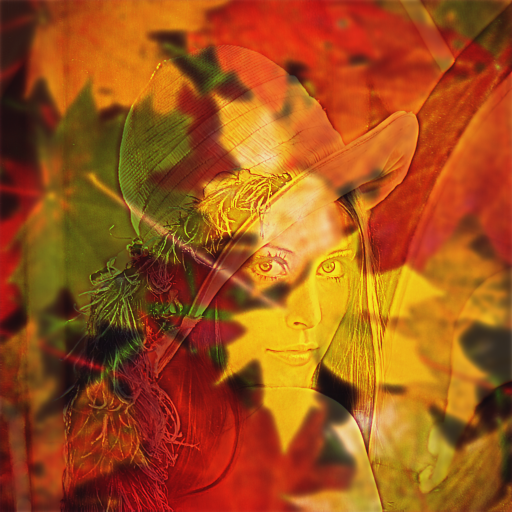

In [16]:
model3 = MyModel(512, 512, gauss_kernel_size=15, image_source=r2.image_source)

for i in range(500):
    r3 = model3.run(imgs[0], imgs[1], m_precise=1.0)
    if i % 50 == 49:
        print(f"{i}: loss = {r3.loss}, precise = {r3.loss_precise}, gauss = {r3.loss_gauss}")
    model3.apply_gradient(r3.gradient, 0.1)

Image.fromarray(np.uint8(r3.image * 255.0))

In [17]:
for i in range(500):
    r3 = model3.run(imgs[0], imgs[1], m_precise=1.0)
    if i % 50 == 49:
        print(f"{i}: loss = {r3.loss}, precise = {r3.loss_precise}, gauss = {r3.loss_gauss}")
    model3.apply_gradient(r3.gradient, 0.1)

Image.fromarray(np.uint8(r3.image * 255.0))

49: loss = 54073.86933136028, precise = 40975.73417081382, gauss = 13098.135160546459


KeyboardInterrupt: 